In [7]:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from numpy import hstack, vstack
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import hamming_loss, make_scorer, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize 
from keras import backend as K  
from gensim.models import Word2Vec 

from nltk.tokenize import WordPunctTokenizer
from nltk.probability import FreqDist

import warnings
warnings.filterwarnings("ignore")

In [8]:

questions= pd.read_csv('data/Questions.csv', encoding='iso-8859-1')
answers=pd.read_csv('data/Answers.csv', encoding='iso-8859-1')
tags=pd.read_csv('data/Tags.csv', encoding='iso-8859-1')

# Combine Tags

In [9]:
tags['Tag'] = tags['Tag'].astype(str)

In [11]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))


In [12]:
grouped_tags.reset_index()
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})


In [13]:
grouped_tags_final

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


# Drop unnecessary columns

In [14]:
questions.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)
questions = questions.merge(grouped_tags_final, on='Id')


# Filtering out questions 

In [15]:
new_df = questions[questions['Score']>5]

print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


# Selection of top 100 tags

In [16]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]
my_set = set(all_tags)
unique_tags = list(my_set)


In [17]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)
keywords = nltk.FreqDist(keywords)
frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]


In [94]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('tags_features.p', 'wb') as fp:
    pickle.dump(tags_features, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [95]:
with open('tags_features.p', 'rb') as tp:
    tags_features = pickle.load(tp)

In [18]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

# Drop the tag if the tag is not in top 100
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))

# Replacing the non tag featured dataset with a none element
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)


In [19]:
new_df.dropna(subset=['Tags'], inplace=True)


In [20]:
new_df

,Id,Score,Title,Body,Tags
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
5,330,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]"
...,...,...,...,...,...
1262834,40110020,6,STL list very bad performance,"<p>It's supposed that ""push_back"" and ""pop_fro...","[c++, list]"
1262915,40111730,7,How to use a dict to subset a DataFrame?,"<p>Say, I have given a DataFrame with most of ...",[python]
1263065,40115300,7,Is there a way to use itertools in python to c...,<p>Let's say I have the following code:</p>\n\...,[python]
1263454,40125310,6,Why does my result data returned as void* gets...,<p>I am working in a project with a huge legac...,[c++]


# Cleaning of Body column

1. Removing of html tags and contracted words

In [21]:
# print(new_df['Body'].head(5))
new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 
# print(new_df['Body'].head(5))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 
# print(new_df['Body'].head(5))

2. Removing of punctuations

In [22]:
token=nltk.ToktokTokenizer()

punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

def strip_list_noempty(mylist):
    # To check if the object is of string type
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    # Same can be achieved using remove punctuation(stopwords)
    regex = re.compile('[%s]' % re.escape(punct))
    
    #Never appears again?
    remove_punctuation = str.maketrans(' ', ' ', punct)
    
    #Removes punctuation from words which are not features
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)

        else:
            punctuation_filtered.append(regex.sub('', w))
    # Takes only string elements(as strip is a feature of string data type)        
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [103]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('new_stop_words.p', 'wb') as fp:
    pickle.dump(new_stop_words, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('new_stop_words.p', 'rb') as nsp:
    new_stop_words = pickle.load(nsp)

In [27]:
lemma=nltk.WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words("english"))

def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(nltk.corpus.stopwords.words("english"))
    stop_words.update(new_stop_words)

    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))


In [28]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
print(new_df['Body'].head(5))

new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 
print(new_df['Body'].head(5))

1    be there any really good tutorials explain bra...
2    have anyone get experience create sql-based as...
3    this be something i have pseudo-solved many ti...
4    i have a little game write in c it use a datab...
5    i be work on a collection of class use for vid...
Name: Body, dtype: object
1    really good tutorials explain branch merge apa...
2    anyone get experience create sql-based asp.net...
3    something pseudo-solved many time never quite ...
4    little game write c use database back-end trad...
5    work collection class use video playback recor...
Name: Body, dtype: object


In [29]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

In [30]:
print(new_df['Title'].head(5))

1       good branch merge tutorials tortoisesvn
2                              asp.net site map
3                   function create color wheel
4    add script functionality .net applications
5                           use nest class case
Name: Title, dtype: object


In [31]:
new_df['Title'].shape

(63167,)

# Changing the dataset for Deep Learning

In [32]:
from nltk.tokenize import WordPunctTokenizer
from collections import Counter

tokenizer = WordPunctTokenizer()

vocab = Counter()
corpus=[]

for j in range(len(new_df['Title'])):
        temp= tokenizer.tokenize(new_df['Title'].iloc[j])
        corpus.append(temp) 
        # To keep track of our vocabulary
        vocab.update(temp)
 

In [33]:
model1 = Word2Vec(sentences=corpus, size = 100, window = 2) 

In [34]:
word_vectors = model1.wv

print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 5123


In [35]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

In [36]:
from keras.preprocessing.sequence import pad_sequences

train_size=44000

# Creating word index based on their frequency
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

# Embed the data

full_sequences = [[word_index.get(t) for t in title]
             for title in new_df['Title'].str.split()]

fs_cleaned= [[0 if v is None else v for v in seq] for seq in full_sequences]

sequences = fs_cleaned[:train_size]

test_sequences = fs_cleaned[train_size:]


In [39]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('word_index.p', 'wb') as fp:
    pickle.dump(word_index, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
# pad
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

y = new_df['Tags'][:train_size]
y_single_train= pd.Series([item[0] for item in y])
le= LabelEncoder()
y_single= pd.Series([item[0] for item in new_df['Tags']])
le.fit(y_single)
y_bin = le.transform(y_single_train)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y_bin.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

Shape of data tensor: (44000, 200)
Shape of label tensor: (44000,)
Shape of test_data tensor: (19167, 200)


In [105]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('label_encoder.p', 'wb') as fp:
    pickle.dump(le, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
y_test = new_df['Tags'][train_size:]
y_single_test= pd.Series([item[0] for item in y_test])
y_test_bin = le.transform(y_single_test)


In [42]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab)+1)

# Initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0

for word, i in word_index.items():
#     if i >= MAX_NB_WORDS:
#         continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass 

In [43]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

In [44]:
# EVALUATION METRIC
def avg_jacard_score(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
#     y_pred= K.sum(K.round((y_pred)))
#     y_true= K.sum(K.round((y_true)))
   
#     jacard = K.minimum(y_true,y_pred).sum(axis=1) / K.maximum(y_true,y_pred).sum(axis=1)
    jacard = K.sum(K.minimum(y_true,y_pred)) / K.sum(K.maximum(y_true,y_pred))
    return K.sum(jacard)/19167


In [45]:
# y_pred= np.round(np.clip(y_pred))
# y_true= np.round(np.clip(y_true))
np.round(y_bin)

array([84, 81,  2, ..., 13, 47, 46])

In [46]:
model = Sequential()

model.add(Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(32))


model.add(Dense(100,init='uniform', activation='sigmoid'))


# model.compile(loss='binary_crossentropy',
#               optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
#               metrics=[avg_jacard_score])
              

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99))
                  


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [47]:
from keras.utils import to_categorical 

y_binary = to_categorical(y_bin)


In [48]:
hist=model.fit([data], y_binary, validation_split=0.1,
                 epochs=20, batch_size=256, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 39600 samples, validate on 4400 samples
Epoch 1/20
39600/39600 [==============================] - 139s 4ms/step - loss: 3.8309 - val_loss: 3.5618
Epoch 2/20
39600/39600 [==============================] - 135s 3ms/step - loss: 3.5335 - val_loss: 3.5389
Epoch 3/20
39600/39600 [==============================] - 132s 3ms/step - loss: 3.5005 - val_loss: 3.5025
Epoch 4/20
39600/39600 [==============================] - 128s 3ms/step - loss: 3.4186 - val_loss: 3.3964
Epoch 5/20
39600/39600 [==============================] - 132s 3ms/step - loss: 3.2874 - val_loss: 3.2741
Epoch 6/20
39600/39600 [==============================] - 138s 3ms/step - loss: 3.1287 - val_loss: 3.1349
Epoch 7/20
39600/39600 [==============================] - 131s 3ms/step - loss: 2.9541 - val_loss: 2.9948
Epoch 8/20
39600/39600 [==============================] - 136s 3ms/step - loss: 2.7744 - val_loss: 2.8387
Epoch 9/20
39600/39600 [==============================]

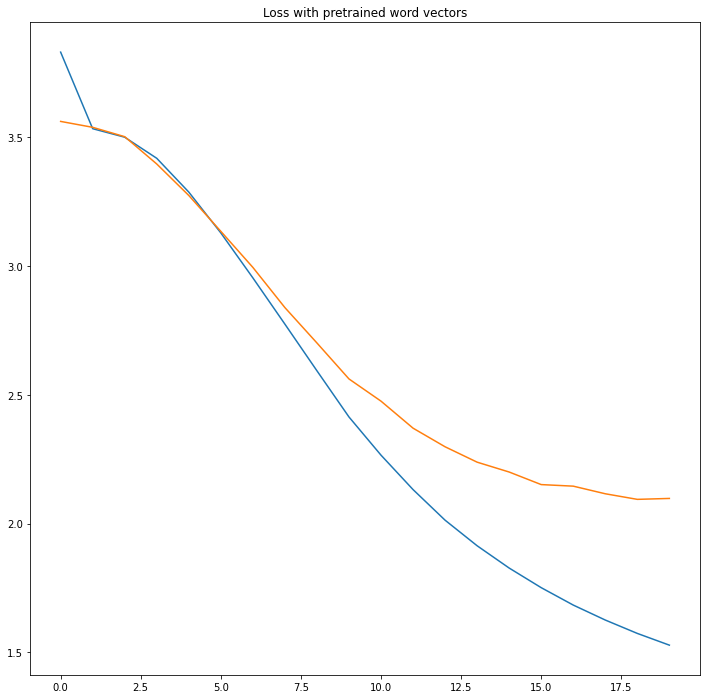

In [49]:
import matplotlib.pyplot as plt
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12))
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Loss with pretrained word vectors")
plt.show()

In [ ]:
# result = np.where(test_data == 5123)
# listOfCoordinates= list(zip(result[0], result[1]))
# for cord in listOfCoordinates:
#     print(cord)



y_pred=model.predict([test_data])

In [ ]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    return jacard.mean()
  

def print_score(y_pred, y_test_bin):
#     print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test_bin, y_pred))) # Higher the better
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test_bin))) # Lower the better
    print("---")    

In [ ]:
# a=np.argmax(y_test_bin, axis=1)
# b=np.argmax(y_pred, axis=1)
# print_score(b,a)
avg_jacard(y_pred, y_test_bin)
# y_pred.shape
# y_test_bin.shape

--------------------------------------------------------------------------------------------------------------

# TESTING SENTENCES (NEW)

In [86]:
test_sentence= "jquery: Unpacking a list of dictionaries in cell to columns"

test_sentence = clean_text(test_sentence) 
test_sentence = clean_punct(test_sentence) 
test_sentence = lemitizeWords(test_sentence) 
test_sentence = stopWordsRemove(test_sentence) 

test_sentence

'jquery unpack list dictionaries cell columns'

In [87]:
ts_1=[word_index.get(title) for title in test_sentence.split(" ")]

test_data = pad_sequences([ts_1], maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")

In [88]:
y_test=model.predict([test_data])




In [106]:
from sklearn.externals import joblib

# joblib.dump(model, 'tag_prediction.joblib')

model.save('stack_overflow_tag.h5')


In [ ]:
from tensorflow import keras
model_load = keras.models.load_model('stack_overflow_tag.h5')

In [89]:
s=np.argmax(y_test, axis=None, out=None)
s

47

In [90]:
# def binarise(x):
#     if x>0.05:
#         return 1
#     return 0

# new_arr=[[binarise(x) for x in tag]
#              for tag in y_test]
# new_arr2=np.asarray(new_arr)
model_tags=le.inverse_transform([s])

In [91]:
model_tags

array(['javascript'], dtype=object)

In [92]:
# model_tags=multilabel_binarizer.inverse_transform(new_arr2)
# model_tags = [item for sublist in model_tags for item in sublist]    
# tokenizer2=WordPunctTokenizer()
# fd = FreqDist()

tag_freq=1
test_words=tokenizer2.tokenize(test_sentence)

for word_token in test_words:
    freq= fd.freq(word_token)
    print(word_token, freq)
#     print(tag_freq)
    if freq< tag_freq:
        tag_freq=freq
        word=word_token

print(word, tag_freq)

if ~(len(model_tags)):
    model_tags_1=[word]

    
print(model_tags_1)

jquery 0.0005831164725383961
unpack 1.837659148939211e-05
list 0.001831023157568042
dictionaries 1.7695976989784998e-05
cell 0.00024859444598149884
columns 0.00026543965484677497
dictionaries 1.7695976989784998e-05
['dictionaries']


In [78]:
set([model_tags[0],model_tags_1[0]])

{'procedures', 'python'}

In [101]:
new_stop_words = open('stop_words.txt','r').read().split(",")

new_stop_words = [x.strip(' ') for x in stop_words]


In [102]:
for x in range(len(new_stop_words)):
    new_stop_words[x]=new_stop_words[x].replace('"','')

In [ ]:
# new_stop_words

----------------------------------------------------------------------
# IGNORE

# TESTING SENTENCES

In [ ]:
test_sentence="help python"

In [ ]:
ts_1=[[word_index.get(t, 0) for t in title]
             for title in test_sentence.split()]

In [ ]:
for title in test_sentence.split():
    print(title)

In [ ]:
new_l=[]
for x in range(len(ts_1)):
    new_l.append(ts_1[x][0])

In [ ]:
print(len(new_l))
print(len(set(new_l)))

In [ ]:
print(len(new_l))
print(len(set(new_l)))

In [ ]:
print(len(new_l))
print(len(set(new_l)))

In [ ]:
ts_2=pad_sequences(ts_1, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

In [104]:
MAX_SEQUENCE_LENGTH

200

In [ ]:
test_result=model.predict(ts_2)

In [ ]:
test_result.shape

In [ ]:
def binarise(x):
    if x>0.00000001:
        return 1
    return 0

In [ ]:
# df=pd.DataFrame(test_result)
# new_arr=[x for x in binarise(test_result)]
new_arr=[[binarise(x) for x in tag]
             for tag in test_result]
new_arr2=np.asarray(new_arr)

In [ ]:
new_df[train_size:train_size+5]

In [64]:
tokens=[]
tokenizer2=WordPunctTokenizer()
for j in range(len(new_df['Body'])):
        temp= tokenizer2.tokenize(new_df['Body'].iloc[j])
        tokens.append(temp) 

tokens = [item for sublist in tokens for item in sublist]        

In [65]:
fd = FreqDist()

for word_token in tokens:
    fd.update([word_token])

In [ ]:
test_sentence= "Appending information and graphs in Excel using python"

test_sentence = clean_text(test_sentence) 
test_sentence = clean_punct(test_sentence) 
test_sentence = lemitizeWords(test_sentence) 
test_sentence = stopWordsRemove(test_sentence) 


ts_1=[[word_index.get(t, 0) for t in title]
             for title in test_sentence.split()]

ts_2=pad_sequences(ts_1, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

In [ ]:

test_result=model.predict(ts_3)


In [ ]:
max_list=[]
for x in range(len(test_result)):
    max_list.append(max(test_result[x]))
    
max(max_list)    

In [ ]:
# multilabel_binarizer.inverse_transform(test_result)
# y = new_df['Tags'][:train_size]
# multilabel_binarizer = MultiLabelBinarizer()
# multilabel_binarizer.fit(new_df['Tags'])
# y_bin = multilabel_binarizer.transform(y)



def binarise(x):
    if x>0.01:
        return 1
    return 0

new_arr=[[binarise(x) for x in tag]
             for tag in test_result]
new_arr2=np.asarray(new_arr)
multilabel_binarizer.inverse_transform(new_arr2)


In [ ]:
new_arr=[[binarise(x) for x in tag]
             for tag in test_result]
new_arr2=np.asarray(new_arr)

In [ ]:
model_tags=multilabel_binarizer.inverse_transform(new_arr2)
model_tags = [item for sublist in model_tags for item in sublist]    
tag_freq=1
test_words=tokenizer2.tokenize(test_sentence)

for word_token in test_words:
    freq= fd.freq(word_token)
    print(word_token, freq)
    print(tag_freq)
    if freq< tag_freq:
        tag_freq=freq
        word=word_token

print(word, tag_freq)

if ~(len(model_tags)):
    model_tags=[word]

    
print(model_tags)